In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import  applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')
import random
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import glob
import shutil
import os
import itertools
from sklearn.metrics import confusion_matrix ,classification_report
from keras.layers import Input,Flatten
from keras.models import Model
from random import randint

## Data Processing

In [2]:
train_path = 'seg_train'

test_path = 'seg_test'

In [3]:
img_size = (150,150)

train_images_p = ImageDataGenerator(
    preprocessing_function=
    tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_path,target_size= (150,150),batch_size=10)

Found 14034 images belonging to 6 classes.


In [4]:
test_images_p=ImageDataGenerator(
    preprocessing_function=
    tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path,
    target_size= (150,150),batch_size=10,shuffle=False)

Found 3000 images belonging to 6 classes.


## VGG16 model Training

In [5]:
from tensorflow.keras.applications import VGG16

In [6]:
from tensorflow.keras.applications import VGG16

pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False


last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = Flatten()(last_output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)                  
x = Dense(6, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 

last layer of vgg : output shape:  (None, 4, 4, 512)


In [7]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
model_vgg.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [9]:
result = model_vgg.fit_generator(test_images_p, epochs=10, validation_data=test_images_p)

Epoch 1/10
300/300 [==============================] - 74s 241ms/step - loss: 2.5397 - accuracy: 0.6837 - val_loss: 0.3238 - val_accuracy: 0.9140
Epoch 2/10
300/300 [==============================] - 75s 251ms/step - loss: 0.4903 - accuracy: 0.8737 - val_loss: 0.1146 - val_accuracy: 0.9580
Epoch 3/10
300/300 [==============================] - 76s 252ms/step - loss: 0.2055 - accuracy: 0.9310 - val_loss: 0.0783 - val_accuracy: 0.9703
Epoch 4/10
300/300 [==============================] - 75s 252ms/step - loss: 0.1152 - accuracy: 0.9603 - val_loss: 0.0341 - val_accuracy: 0.9900
Epoch 5/10
300/300 [==============================] - 76s 253ms/step - loss: 0.0960 - accuracy: 0.9670 - val_loss: 0.0188 - val_accuracy: 0.9967
Epoch 6/10
300/300 [==============================] - 76s 252ms/step - loss: 0.0640 - accuracy: 0.9753 - val_loss: 0.0144 - val_accuracy: 0.9967
Epoch 7/10
300/300 [==============================] - 75s 251ms/step - loss: 0.0510 - accuracy: 0.9823 - val_loss: 0.0091 - val_ac

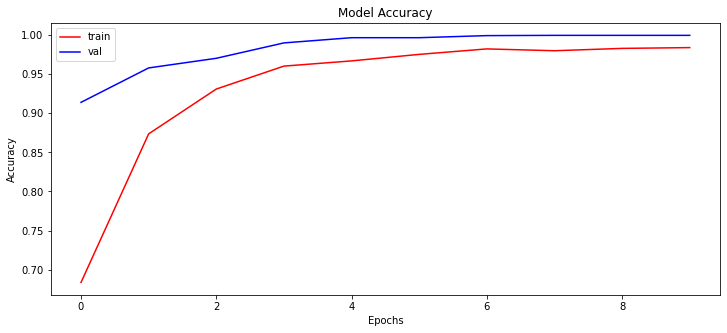

In [11]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(result.history['accuracy'], color='r')
plt.plot(result.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

### AS expected the transfer learning working very good on the data with no overfitting

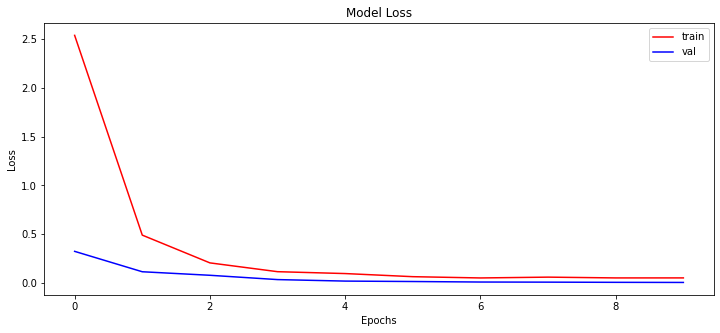

In [13]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(result.history['loss'], color='r')
plt.plot(result.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [33]:
predictions = model_vgg.predict(test_images_p)
predictions

array([[1.0000000e+00, 1.1993656e-16, 2.5212320e-22, 5.8839121e-20,
        9.0798134e-17, 4.8767860e-18],
       [9.9999416e-01, 5.6035419e-06, 1.2978886e-10, 4.4294039e-13,
        4.1984311e-12, 1.9186412e-07],
       [1.0000000e+00, 6.4287071e-18, 3.5078512e-25, 5.2779286e-27,
        5.4771167e-26, 7.6267048e-12],
       ...,
       [1.3468750e-05, 2.2907935e-04, 7.2911368e-03, 5.5284370e-03,
        7.7259188e-05, 9.8686057e-01],
       [3.1100460e-06, 3.0353884e-05, 4.5099036e-08, 4.0372248e-09,
        1.1641236e-08, 9.9996650e-01],
       [1.8406038e-12, 1.3641761e-15, 2.5428114e-21, 2.2342976e-18,
        2.2089696e-15, 1.0000000e+00]], dtype=float32)

In [34]:
predictions = np.argmax(predictions, axis=1)

In [36]:
predictions

array([0, 0, 0, ..., 5, 5, 5], dtype=int64)

In [24]:
test_loss, test_accuracy = model_vgg.evaluate(test_images_p, batch_size=32)

300/300 [==============================] - 35s 116ms/step - loss: 0.0048 - accuracy: 0.9997


In [20]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.004848218057304621
Test Accuracy: 0.999666690826416


In [45]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [71]:
def classify_image(picture):
    img = image.load_img(f'{picture}', target_size=(150,150))
    x = image.img_to_array(img)
    x = x/255
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    return np.argmax(model_vgg.predict(img_data), axis=1)
    

In [76]:
classify_image('seg_pred/84.jpg')

array([4], dtype=int64)

In [77]:
img = image.load_img('seg_pred/84.jpg', target_size=(150,150))

In [78]:
x = image.img_to_array(img)
x

array([[[107., 150., 192.],
        [107., 150., 192.],
        [107., 150., 192.],
        ...,
        [ 96., 135., 174.],
        [ 95., 135., 171.],
        [ 94., 134., 170.]],

       [[107., 150., 193.],
        [106., 151., 193.],
        [107., 152., 194.],
        ...,
        [ 97., 135., 172.],
        [ 98., 136., 173.],
        [ 98., 138., 174.]],

       [[105., 152., 196.],
        [105., 152., 196.],
        [106., 153., 197.],
        ...,
        [ 97., 135., 172.],
        [100., 138., 175.],
        [102., 140., 176.]],

       ...,

       [[ 62.,  67.,  61.],
        [ 66.,  71.,  64.],
        [ 71.,  74.,  67.],
        ...,
        [ 42.,  23.,   6.],
        [ 45.,  24.,   7.],
        [ 44.,  23.,   6.]],

       [[ 66.,  73.,  66.],
        [ 68.,  73.,  67.],
        [ 71.,  74.,  67.],
        ...,
        [ 44.,  22.,   8.],
        [ 44.,  22.,   8.],
        [ 44.,  22.,   8.]],

       [[ 54.,  64.,  56.],
        [ 57.,  64.,  57.],
        [ 55.,  

In [79]:
x.shape

(150, 150, 3)

In [80]:
x = x/255

In [81]:
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
img_data.shape

(1, 150, 150, 3)

In [82]:
a = np.argmax(model_vgg.predict(img_data), axis=1)

In [83]:
a

array([4], dtype=int64)

#### save model for deployemnt

In [22]:
from tensorflow.keras.models import load_model

model_vgg.save('intel_image.h5')

## Conclusion - by using transfer learning VGG16 we model achieved accuracy of 99% on test data. which is far more than the CNN model created earlier.